In [13]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob
from PIL import Image
import functools

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Open image

In [6]:
image = []
slice_position = []
for pngfile in tqdm.tqdm(sorted(glob.glob(f'{parent}/assets/hand_CT/*.png'))):
    png = np.array(Image.open(pngfile))
    image.append(png)
    # slice_position.append(dcm.SliceLocation)
    
image = np.stack(image, axis=-1)
# voxel_size = np.array([
#     float(dcm.PixelSpacing[0]),
#     float(dcm.PixelSpacing[1]),
#     np.abs((float(slice_position[0]) - float(slice_position[-1])) / (len(slice_position) - 1))
# ])/1000

100%|██████████| 1000/1000 [00:00<00:00, 9569.20it/s]


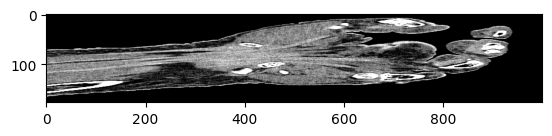

In [7]:
plt.imshow(image[60,:,:], cmap='gray')

In [8]:
voxel_size = np.array([0.00065, 0.00065, 0.0002])

In [9]:
def transfer_function(image, method='first'):
    if method == 'first':
        density = np.zeros_like(image)
        density = np.where(image < -365, 1.0491 + 1.0526e-3 * image, density)
        density = np.where(image >= -365, 1.0053 + 8.921e-4 * image, density)
        density = np.where(image >= 255, 1.0610 + 6.813e-4 * image, density)
        density = density * 1000 # Conversion from g/cm^3 to kg/m^3
    elif method == 'second':
        density = np.zeros_like(image)
        density = np.where(image < 148, 1.0168 + 9.836e-4 * image, density)
        density = np.where(image >= 148, 1.1786 + 2.216e-4 * image, density)
        density = density * 1000 # Conversion from g/cm^3 to kg/m^3
    elif method == 'third':
        density = np.zeros_like(image)
        density = np.where(image < 104, 1.0050 + 0.0010 * image, density)
        density = np.where(image >= 104, 1.0152 + 0.0006 * image, density)
        density = density * 1000 # Conversion from g/cm^3 to kg/m^3
    else:
        print("transfer function method not recognized, supply as one of [first, second, third]")
        return 0
    return density

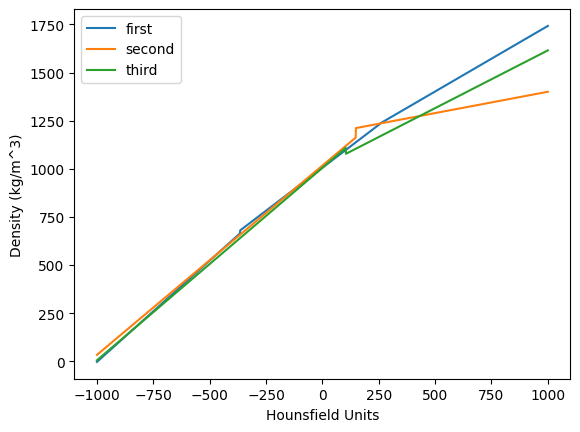

In [10]:
plt.plot(np.linspace(-1000,1000,2000), transfer_function(np.linspace(-1000,1000,2000), method='first'))
plt.plot(np.linspace(-1000,1000,2000), transfer_function(np.linspace(-1000,1000,2000), method='second'))
plt.plot(np.linspace(-1000,1000,2000), transfer_function(np.linspace(-1000,1000,2000), method='third'))
plt.xlabel('Hounsfield Units')
plt.ylabel('Density (kg/m^3)')
plt.legend(['first', 'second', 'third'])

In [11]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
                               matrix_dims = (350,350,350),
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

In [14]:
test_phantom.create_from_image(image, voxel_size, transfer_fn=functools.partial(transfer_function, method='first'), scale_w_noise=True)

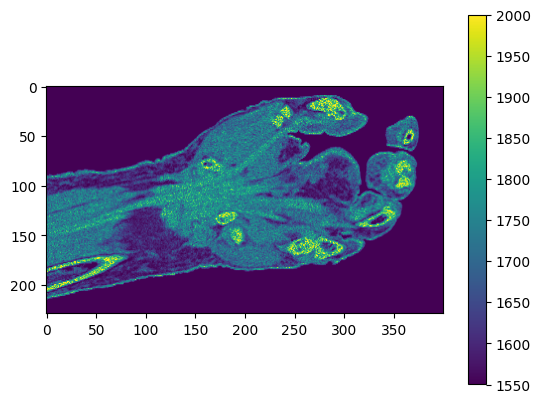

In [15]:
plt.imshow(test_phantom.get_complete()[0,80,:,:], vmin=1550, vmax=2000)
plt.colorbar()

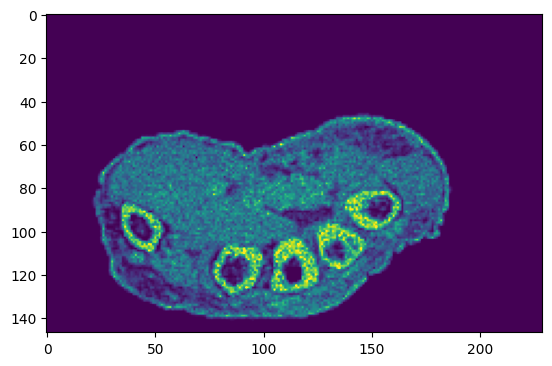

In [16]:
plt.imshow(test_phantom.get_complete()[0,:,:,200], vmin=1550, vmax=2000)

In [22]:
test_phantom.save('noisy_hand_phantom')

In [17]:
test_phantom.create_from_image(image, voxel_size, transfer_fn=functools.partial(transfer_function, method='first'), scale_w_noise=False)

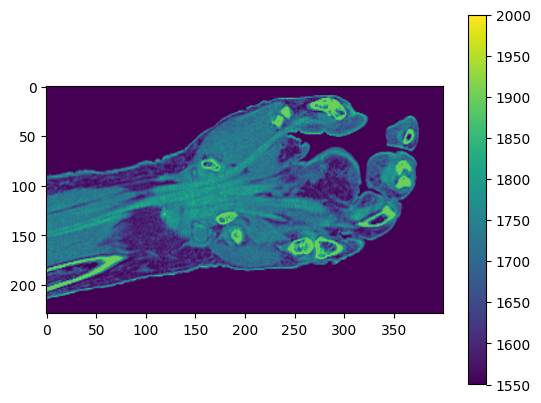

In [18]:
plt.imshow(test_phantom.get_complete()[0,80,:,:], vmin=1550, vmax=2000)
plt.colorbar()

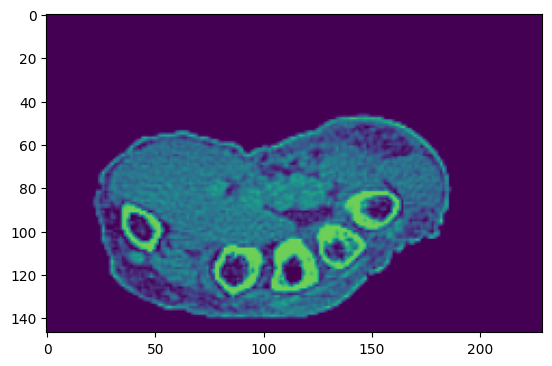

In [19]:
plt.imshow(test_phantom.get_complete()[0,:,:,200], vmin=1550, vmax=2000)

In [20]:
test_phantom.save(f'{parent}/assets/hand_phantom')

In [16]:
test_phantom.get_complete().shape

(2, 147, 229, 400)

In [ ]:
plt.imshow(test_phantom.get_complete()[1][:,:,0])
plt.colorbar()

In [ ]:
test_phantom.get_complete()

In [ ]:
# utils.save_mrc(test_phantom.get_complete(), '../experiment_files/images/Patient_10/phantom_5e-4.mrc')

test_phantom.save('../experiment_files/cardiac_phantom')

In [ ]:
plt.imshow(np.where(test_phantom.get_complete()[1][:,:,127] > 1600, 1, 0))

In [ ]:
array_2_mesh = np.where(test_phantom.get_complete()[1] > 1600, 1, 0)

In [ ]:
import mcubes

In [ ]:

# Marching cubes without smoothing
vertices_unsmooth, triangles_unsmooth = mcubes.marching_cubes(array_2_mesh, 0.5)
mcubes.export_obj(vertices, triangles, 'heartCT.obj')

# # Marching cubes with smoothing
# smoothed_heartCT = mcubes.smooth(array_2_mesh)
# vertices, triangles = mcubes.marching_cubes(smoothed_heartCT, 0)
# mcubes.export_obj(vertices, triangles, 'smooth_heartCT.obj')

In [ ]:
# Create a data volume (30 x 30 x 30)
X, Y, Z = np.mgrid[:30, :30, :30]
u = (X-15)**2 + (Y-15)**2 + (Z-15)**2 - 8**2

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(u, 0.5)

# Export the result to sphere.obj
# mcubes.export_obj(vertices, triangles, 'sphere.obj')

In [ ]:
x, y, z = np.mgrid[:100, :100, :100]
binary_sphere = ((x - 50)**2 + (y - 50)**2 + (z - 50)**2 - 25**2 < 0) + ((x - 35)**2 + (y - 43)**2 + (z - 77)**2 - 20**2 < 0) + ((x - 75)**2 + (y - 35)**2 + (z - 75)**2 - 15**2 < 0) > 0

# Extract the 0.5-levelset since the array is binary
vertices, triangles = mcubes.marching_cubes(binary_sphere, 0.5)

mcubes.export_obj(vertices, triangles, 'sphere_rough.obj')

In [ ]:
smoothed_sphere = mcubes.smooth(binary_sphere)

# Extract the 0-levelset (the 0-levelset of the output of mcubes.smooth is the
# smoothed version of the 0.5-levelset of the binary array).
vertices, triangles = mcubes.marching_cubes(smoothed_sphere, 0)

mcubes.export_obj(vertices, triangles, 'sphere_smooth.obj')

In [ ]:
mcubes.open('experiment_files/images/Aorta.obj')

In [ ]:
import pymeshlab

In [ ]:
ms = pymeshlab.MeshSet()

In [ ]:
new_object = ms.load_new_mesh('../experiment_files/images/Aorta.obj')

In [ ]:
new_object

# Make from vox

In [ ]:
from midvoxio.voxio import vox_to_arr

In [ ]:
blood_mask = vox_to_arr('../experiment_files/images/blood.vox')
myocardium_mask = vox_to_arr('../experiment_files/images/myocardium.vox')

In [ ]:
blood_mask = np.where(np.sum(blood_mask, axis=-1) > 0, 1, 0)
myocardium_mask = np.where(np.sum(myocardium_mask, axis=-1) > 0, 1, 0)

In [ ]:
plt.imshow(blood_mask[:,:,128])

In [ ]:
plt.imshow(myocardium_mask[:,:,128])

In [ ]:
# combined = np.stack((blood, myocardium, np.zeros_like(blood)), axis=-1)
# combined = combined.astype(np.uint8)
# plt.imshow(combined[:,:,115,:]*255)

In [ ]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
                               matrix_dims = (256,256,256),
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=2.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)


In [ ]:
test_phantom.add_tissue(fat, mask=np.ones((256,256,256)))
test_phantom.add_tissue(myocardium, mask=myocardium_mask)
test_phantom.add_tissue(blood, mask=blood_mask)
test_phantom.set_default_tissue('fat')

In [ ]:
plt.imshow(test_phantom.get_complete()[0,:,:,80])

In [ ]:
test_phantom.save('../experiment_files/cardiac_phantom')
utils.save_mrc(test_phantom.get_complete(), '../experiment_files/cardiac_phantom/cardiac_phantom.mrc')

# Meshlib

In [ ]:
import meshlib

In [ ]:
from meshlib import mrmeshpy as mm
from meshlib import mrmeshnumpy as mn
import numpy as np
import plotly.graph_objects as go
 
# load mesh
mesh = mm.loadMesh("../demos/healthy_stationary_heart.stl")
# extract numpy arrays
verts = mn.getNumpyVerts(mesh)
faces = mn.getNumpyFaces(mesh.topology)
 
# prepare data for plotly
verts_t = np.transpose(verts)
faces_t = np.transpose(faces)
 
# draw
fig = go.Figure(data=[
    go.Mesh3d(
        x=verts_t[0],
        y=verts_t[1],
        z=verts_t[2],
        i=faces_t[0],
        j=faces_t[1],
        k=faces_t[2]
    )
])
 
fig.show()
